In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.discrete.discrete_model import Logit
import statsmodels.tools as sm
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve,accuracy_score

In [2]:
data=pd.read_excel("Affairs.xlsx")

In [3]:
data.head()

,ID,affairs,gender,age,yearsmarried,children,religiousness,education,occupation,rating
0,4,0,male,37.0,10.00,no,3,18,7,4
1,5,0,female,27.0,4.00,no,4,14,6,4
2,11,0,female,32.0,15.00,yes,1,12,1,4
3,16,0,male,57.0,15.00,yes,5,18,6,5
4,23,0,male,22.0,0.75,no,2,17,6,3


In [4]:
data.drop("ID",axis=1,inplace=True)

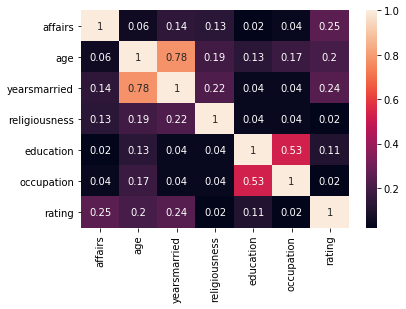

In [5]:
sns.heatmap(data.corr().abs().round(2),annot=True)
plt.show()

In [6]:
data.drop("age",inplace=True,axis=1)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 601 entries, 0 to 600
Data columns (total 8 columns):
affairs          601 non-null int64
gender           601 non-null object
yearsmarried     601 non-null float64
children         601 non-null object
religiousness    601 non-null int64
education        601 non-null int64
occupation       601 non-null int64
rating           601 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 37.6+ KB


In [8]:
print((data.affairs.value_counts()/len(data)*100).round(2))

0    75.04
1    24.96
Name: affairs, dtype: float64


In [9]:
data=pd.get_dummies(data,drop_first=True)

In [10]:
X=data.drop("affairs",axis=1)
Y=data.affairs

In [11]:
#as we are going to use not formula but X and Y data in the logit function, 
#so we need to add the intercept to data (X) manually
X=sm.add_constant(X)

In [12]:
x_train, x_test, y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [13]:
model=Logit(y_train,x_train)
results=model.fit()

Optimization terminated successfully.
         Current function value: 0.498292
         Iterations 6


In [14]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                affairs   No. Observations:                  450
Model:                          Logit   Df Residuals:                      442
Method:                           MLE   Df Model:                            7
Date:                Sat, 23 Mar 2019   Pseudo R-squ.:                  0.1158
Time:                        12:57:13   Log-Likelihood:                -224.23
converged:                       True   LL-Null:                       -253.60
                                        LLR p-value:                 2.699e-10
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.0730      0.947      1.133      0.257      -0.783       2.929
yearsmarried      0.0340      0.026      1.290      0.197      -0.018       0.086
religiousness    -0.3344      0.105     -3.187      0.001      -0.540      -0.129
education        -0.0165      0.059     -0.280      0.779      -0.132       0.099
occupation        0.1457      0.085      1.722      0.085      -0.020       0.312
rating           -0.5691      0.107     -5.341      0.000      -0.778      -0.360
gender_male      -0.1108      0.266     -0.416      0.678      -0.633       0.411
children_yes      0.5312      0.344      1.546      0.122      -0.142       1.205
=================================================================================
"""

In [15]:
results.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                affairs
Method:                          dydx
At:                           overall
=================================================================================
                   dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
yearsmarried      0.0055      0.004      1.297      0.195      -0.003       0.014
religiousness    -0.0545      0.017     -3.297      0.001      -0.087      -0.022
education        -0.0027      0.010     -0.280      0.779      -0.022       0.016
occupation        0.0237      0.014      1.739      0.082      -0.003       0.051
rating           -0.0927      0.015     -6.000      0.000      -0.123      -0.062
gender_male      -0.0181      0.043     -0.416      0.677      -0.103       0.067
children_yes      0.0866      0.056      1.557      0.119      -0.022       0.196
=================================================================================
"""

In [16]:
#let's get predicted probabilities of being churn
y_pred_train=results.predict(x_train)
y_pred_test=results.predict(x_test)
print(y_pred_test.head(),"\n","\n",y_pred_train.head())

110    0.077507
419    0.081720
565    0.089064
77     0.164299
181    0.119587
dtype: float64 
 
 531    0.278971
353    0.071615
332    0.255513
534    0.438957
244    0.220707
dtype: float64


In [17]:
cm=results.pred_table().T
cm

array([[325.,  86.],
       [ 12.,  27.]])

In [20]:
#let's calculate overall accuracy, recall and specificity for train data
Accuracy_train=(cm[0,0]+cm[1,1])/len(data)
Sensitivity_train=cm[1,1]/(cm[0,1]+cm[1,1])
Specificity_train=cm[0,0]/(cm[0,0]+cm[1,0])
print("Accuracy:",Accuracy_train)
print("Sensitivity:",Sensitivity_train)
print("Specificity:",Specificity_train)

Accuracy: 0.5856905158069884
Sensitivity: 0.23893805309734514
Specificity: 0.9643916913946587


In [21]:
y_pred_test=pd.DataFrame(y_pred_test,columns=(["prob"]))
y_pred_test.head()

,prob
110,0.077507
419,0.081720
565,0.089064
77,0.164299
181,0.119587


In [22]:
y_pred_test['Y_Predicted'] = np.where(y_pred_test['prob']>=0.5, '1', '0')
y_pred_test["Y_True"] = y_test
y_pred_test.head()

,prob,Y_Predicted,Y_True
110,0.077507,0,0
419,0.081720,0,0
565,0.089064,0,1
77,0.164299,0,0
181,0.119587,0,0


In [23]:
cm_test=pd.crosstab(y_pred_test.Y_Predicted,y_pred_test.Y_True)
cm_test

Y_True,0,1
Y_Predicted,,
0,104,29
1,10,8


In [24]:
#now let's calculate overall accuracy, recall and specificity for test data
Accuracy_test=(104+8)/len(y_test)
Sensitivity_test=8/(29+8)
Specificity_test=104/(104+10)
print("Accuracy Test:",Accuracy_test)
print("Sensitivity Test:",Sensitivity_test)
print("Specificity Test:",Specificity_test)

Accuracy Test: 0.7417218543046358
Sensitivity Test: 0.21621621621621623
Specificity Test: 0.9122807017543859


In [25]:
#let's calculate true positive rate (recall) and false positive rate (1-specificity) for test data using roc_curve function
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test.prob)

#let's print the first 10 values for different tresholds
print(false_positive_rate[0:5],true_positive_rate[0:10],thresholds[0:10])

[0.         0.00877193 0.02631579 0.02631579 0.03508772] [0.         0.         0.         0.05405405 0.05405405 0.08108108
 0.08108108 0.10810811 0.10810811 0.18918919] [1.75659962 0.75659962 0.70789777 0.63865835 0.62992823 0.62538161
 0.61480881 0.61248352 0.59537142 0.54146555]


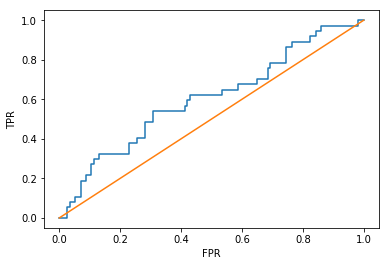

In [26]:
plt.plot(false_positive_rate,true_positive_rate)
plt.plot([0,1],[0,1])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

In [27]:
print("roc_auc:",roc_auc_score(y_test,y_pred_test.prob))

roc_auc: 0.6036036036036037
